In [1]:
import time
import math
import os
import torch.nn as nn

import torch.onnx
import torch
from torch.autograd import Variable
import torch.optim as optim

import model as rnn_model
import data

In [2]:
args_seed = 1234
args_temperature = 1.
args_data = '../data/wikitext-2'
args_model = 'BiLSTM'
args_emsize = 650
args_nhid = 650
args_nlayers = 2
args_clip = 0.25
args_epochs = 40
args_batch_size = 20
args_bptt = 35
args_dropout = 0.2
args_log_interval = 200
args_save = 'model_800_bilstm.pt'
args_save_state = 'model_state_800_bilstm.pt'
args_tied = True

In [3]:
torch.manual_seed(args_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'using device: {device}')

using device: cuda


In [4]:
###############################################################################
# Load data
###############################################################################

corpus = data.Corpus(args_data)

In [5]:
# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

eval_batch_size = 10
train_data = batchify(corpus.train, args_batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

In [6]:
###############################################################################
# Build the model
###############################################################################

ntokens = len(corpus.dictionary)
model = rnn_model.RNNModel(args_model, ntokens, args_emsize, args_nhid, args_nlayers, args_dropout, args_tied).to(device)

criterion = nn.CrossEntropyLoss()

Warning, BiLSTM can not have tied weights!


In [7]:
###############################################################################
# Use Adam optimizer
###############################################################################

# create your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [9]:
# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):
    seq_len = min(args_bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, args_bptt):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)
    return total_loss / len(data_source)


def train():
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(args_batch_size)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, args_bptt)):
        data, targets = get_batch(train_data, i)
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        hidden = repackage_hidden(hidden)
        optimizer.zero_grad()   # zero the gradient buffers
        output, hidden = model(data, hidden)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        optimizer.step()    # Does the update
        total_loss += loss.item()

        if batch % args_log_interval == 0 and batch > 0:
            cur_loss = total_loss / args_log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // args_bptt, 
                elapsed * 1000 / args_log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


In [10]:
# Loop over epochs.
best_val_loss = None

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, args_epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(args_save, 'wb') as f:
                torch.save(model, f)
            ## Save State Dictionary
            with open(args_save_state, 'wb') as f:
                torch.save(model.state_dict(), f)
            best_val_loss = val_loss

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |   200/ 2983 batches | ms/batch 173.20 | loss  9.11 | ppl  9072.09
| epoch   1 |   400/ 2983 batches | ms/batch 159.34 | loss  9.89 | ppl 19745.22
| epoch   1 |   600/ 2983 batches | ms/batch 159.42 | loss 11.06 | ppl 63393.51
| epoch   1 |   800/ 2983 batches | ms/batch 157.12 | loss 11.49 | ppl 98058.75
| epoch   1 |  1000/ 2983 batches | ms/batch 160.20 | loss 11.43 | ppl 92060.07
| epoch   1 |  1200/ 2983 batches | ms/batch 159.26 | loss 12.25 | ppl 208559.52
| epoch   1 |  1400/ 2983 batches | ms/batch 157.40 | loss 13.28 | ppl 584499.78
| epoch   1 |  1600/ 2983 batches | ms/batch 159.97 | loss 13.32 | ppl 611625.56
| epoch   1 |  1800/ 2983 batches | ms/batch 167.79 | loss 12.95 | ppl 419242.55
| epoch   1 |  2000/ 2983 batches | ms/batch 169.17 | loss 13.17 | ppl 525054.45
| epoch   1 |  2200/ 2983 batches | ms/batch 157.24 | loss 13.37 | ppl 639367.40
| epoch   1 |  2400/ 2983 batches | ms/batch 157.13 | loss 13.90 | ppl 1089058.14
| epoch   1 |  2600/ 2983 batche

| epoch   7 |   200/ 2983 batches | ms/batch 158.05 | loss  5.25 | ppl   190.75
| epoch   7 |   400/ 2983 batches | ms/batch 157.40 | loss  5.30 | ppl   200.32
| epoch   7 |   600/ 2983 batches | ms/batch 157.59 | loss  5.31 | ppl   203.34
| epoch   7 |   800/ 2983 batches | ms/batch 157.91 | loss  5.30 | ppl   200.47
| epoch   7 |  1000/ 2983 batches | ms/batch 157.40 | loss  5.26 | ppl   192.83
| epoch   7 |  1200/ 2983 batches | ms/batch 157.44 | loss  5.35 | ppl   209.63
| epoch   7 |  1400/ 2983 batches | ms/batch 157.74 | loss  5.35 | ppl   210.28
| epoch   7 |  1600/ 2983 batches | ms/batch 157.48 | loss  5.47 | ppl   238.64
| epoch   7 |  1800/ 2983 batches | ms/batch 157.40 | loss  5.26 | ppl   192.30
| epoch   7 |  2000/ 2983 batches | ms/batch 157.32 | loss  5.31 | ppl   201.78
| epoch   7 |  2200/ 2983 batches | ms/batch 157.84 | loss  5.28 | ppl   197.30
| epoch   7 |  2400/ 2983 batches | ms/batch 157.40 | loss  5.23 | ppl   186.93
| epoch   7 |  2600/ 2983 batches | ms/b

| epoch  13 |   200/ 2983 batches | ms/batch 165.70 | loss  4.19 | ppl    65.85
| epoch  13 |   400/ 2983 batches | ms/batch 168.01 | loss  4.24 | ppl    69.63
| epoch  13 |   600/ 2983 batches | ms/batch 159.91 | loss  4.16 | ppl    63.82
| epoch  13 |   800/ 2983 batches | ms/batch 163.03 | loss  4.17 | ppl    64.46
| epoch  13 |  1000/ 2983 batches | ms/batch 163.91 | loss  4.16 | ppl    64.34
| epoch  13 |  1200/ 2983 batches | ms/batch 165.64 | loss  4.24 | ppl    69.43
| epoch  13 |  1400/ 2983 batches | ms/batch 161.48 | loss  4.25 | ppl    69.80
| epoch  13 |  1600/ 2983 batches | ms/batch 157.45 | loss  4.28 | ppl    72.12
| epoch  13 |  1800/ 2983 batches | ms/batch 157.41 | loss  4.15 | ppl    63.54
| epoch  13 |  2000/ 2983 batches | ms/batch 162.31 | loss  4.21 | ppl    67.61
| epoch  13 |  2200/ 2983 batches | ms/batch 158.75 | loss  4.17 | ppl    64.59
| epoch  13 |  2400/ 2983 batches | ms/batch 164.72 | loss  4.16 | ppl    64.05
| epoch  13 |  2600/ 2983 batches | ms/b

| epoch  19 |   200/ 2983 batches | ms/batch 157.68 | loss  3.80 | ppl    44.74
| epoch  19 |   400/ 2983 batches | ms/batch 156.93 | loss  3.82 | ppl    45.45
| epoch  19 |   600/ 2983 batches | ms/batch 156.94 | loss  3.78 | ppl    43.66
| epoch  19 |   800/ 2983 batches | ms/batch 156.99 | loss  3.77 | ppl    43.49
| epoch  19 |  1000/ 2983 batches | ms/batch 156.98 | loss  3.74 | ppl    42.01
| epoch  19 |  1200/ 2983 batches | ms/batch 156.94 | loss  3.77 | ppl    43.41
| epoch  19 |  1400/ 2983 batches | ms/batch 156.92 | loss  3.78 | ppl    43.70
| epoch  19 |  1600/ 2983 batches | ms/batch 156.93 | loss  3.81 | ppl    45.24
| epoch  19 |  1800/ 2983 batches | ms/batch 156.95 | loss  3.68 | ppl    39.71
| epoch  19 |  2000/ 2983 batches | ms/batch 156.97 | loss  3.72 | ppl    41.44
| epoch  19 |  2200/ 2983 batches | ms/batch 156.93 | loss  3.67 | ppl    39.37
| epoch  19 |  2400/ 2983 batches | ms/batch 156.92 | loss  3.68 | ppl    39.61
| epoch  19 |  2600/ 2983 batches | ms/b

| epoch  25 |   200/ 2983 batches | ms/batch 157.74 | loss  3.31 | ppl    27.26
| epoch  25 |   400/ 2983 batches | ms/batch 156.91 | loss  3.32 | ppl    27.54
| epoch  25 |   600/ 2983 batches | ms/batch 156.98 | loss  3.24 | ppl    25.56
| epoch  25 |   800/ 2983 batches | ms/batch 156.92 | loss  3.29 | ppl    26.84
| epoch  25 |  1000/ 2983 batches | ms/batch 156.96 | loss  3.28 | ppl    26.54
| epoch  25 |  1200/ 2983 batches | ms/batch 156.94 | loss  3.33 | ppl    27.93
| epoch  25 |  1400/ 2983 batches | ms/batch 156.96 | loss  3.40 | ppl    29.96
| epoch  25 |  1600/ 2983 batches | ms/batch 156.97 | loss  3.41 | ppl    30.16
| epoch  25 |  1800/ 2983 batches | ms/batch 156.92 | loss  3.31 | ppl    27.40
| epoch  25 |  2000/ 2983 batches | ms/batch 156.92 | loss  3.38 | ppl    29.43
| epoch  25 |  2200/ 2983 batches | ms/batch 156.94 | loss  3.32 | ppl    27.65
| epoch  25 |  2400/ 2983 batches | ms/batch 156.90 | loss  3.34 | ppl    28.29
| epoch  25 |  2600/ 2983 batches | ms/b

| epoch  31 |   200/ 2983 batches | ms/batch 157.57 | loss  2.93 | ppl    18.69
| epoch  31 |   400/ 2983 batches | ms/batch 156.80 | loss  2.96 | ppl    19.26
| epoch  31 |   600/ 2983 batches | ms/batch 156.78 | loss  2.85 | ppl    17.34
| epoch  31 |   800/ 2983 batches | ms/batch 156.75 | loss  2.88 | ppl    17.81
| epoch  31 |  1000/ 2983 batches | ms/batch 156.79 | loss  2.88 | ppl    17.80
| epoch  31 |  1200/ 2983 batches | ms/batch 156.84 | loss  2.90 | ppl    18.12
| epoch  31 |  1400/ 2983 batches | ms/batch 156.80 | loss  2.95 | ppl    19.11
| epoch  31 |  1600/ 2983 batches | ms/batch 156.77 | loss  2.96 | ppl    19.32
| epoch  31 |  1800/ 2983 batches | ms/batch 156.77 | loss  2.87 | ppl    17.58
| epoch  31 |  2000/ 2983 batches | ms/batch 156.77 | loss  2.92 | ppl    18.48
| epoch  31 |  2200/ 2983 batches | ms/batch 156.80 | loss  2.90 | ppl    18.11
| epoch  31 |  2400/ 2983 batches | ms/batch 156.75 | loss  2.88 | ppl    17.83
| epoch  31 |  2600/ 2983 batches | ms/b

| epoch  37 |   200/ 2983 batches | ms/batch 157.41 | loss  2.74 | ppl    15.46
| epoch  37 |   400/ 2983 batches | ms/batch 156.62 | loss  2.77 | ppl    15.89
| epoch  37 |   600/ 2983 batches | ms/batch 156.61 | loss  2.71 | ppl    14.98
| epoch  37 |   800/ 2983 batches | ms/batch 156.68 | loss  2.75 | ppl    15.63
| epoch  37 |  1000/ 2983 batches | ms/batch 156.64 | loss  2.76 | ppl    15.82
| epoch  37 |  1200/ 2983 batches | ms/batch 156.64 | loss  2.79 | ppl    16.29
| epoch  37 |  1400/ 2983 batches | ms/batch 156.65 | loss  2.81 | ppl    16.59
| epoch  37 |  1600/ 2983 batches | ms/batch 156.64 | loss  2.83 | ppl    16.88
| epoch  37 |  1800/ 2983 batches | ms/batch 156.61 | loss  2.77 | ppl    15.97
| epoch  37 |  2000/ 2983 batches | ms/batch 156.64 | loss  2.82 | ppl    16.70
| epoch  37 |  2200/ 2983 batches | ms/batch 156.65 | loss  2.79 | ppl    16.25
| epoch  37 |  2400/ 2983 batches | ms/batch 156.63 | loss  2.79 | ppl    16.28
| epoch  37 |  2600/ 2983 batches | ms/b

In [11]:
# Load the best saved model.
with open(args_save, 'rb') as f:
    model = torch.load(f)
    # after load the rnn params are not a continuous chunk of memory
    # this makes them a continuous chunk, and will speed up forward pass
    model.rnn.flatten_parameters()

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)


| End of training | test loss  2.77 | test ppl    15.93


# Try to generate with this model now

In [38]:
args_data = '../data/wikitext-2'
args_checkpoint = args_save #'./model.pt'
args_state_dict = args_save_state # './model_state.pt'
args_outf = 'generated_800_bilstm.txt'
args_words = 1000
args_seed = 1234
args_temperature = 3.0
args_log_interval = 100

In [34]:
# Set the random seed manually for reproducibility.
torch.manual_seed(args_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [ ]:
if args_temperature < 1e-3:
    print("args_temperature has to be greater or equal 1e-3")


In [ ]:
corpus = data.Corpus(args_data)
ntokens = len(corpus.dictionary)

In [ ]:
with open(args_checkpoint, 'rb') as f:
    model = torch.load(f).to(device)

# model = rnn_model.RNNModel(args_model, ntokens, args_emsize, args_nhid, args_nlayers, args_dropout, args_tied).to(device)
# with open(args_state_dict, 'rb') as f:
#     state_dict = torch.load(f)
#     model.load_state_dict(state_dict)

model.rnn.flatten_parameters()

In [35]:
hidden = model.init_hidden(1)
input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)

In [39]:
model.eval()

RNNModel(
  (drop): Dropout(p=0.2)
  (encoder): Embedding(33278, 650)
  (rnn): LSTM(650, 650, num_layers=2, dropout=0.2, bidirectional=True)
  (decoder): Linear(in_features=1300, out_features=33278, bias=True)
)

In [40]:
with open(args_outf, 'w') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args_words):
            output, hidden = model(input, hidden)
            word_weights = output.squeeze().div(args_temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_idx)
            word = corpus.dictionary.idx2word[word_idx]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args_log_interval == 0:
                print('| Generated {}/{} words'.format(i, args_words))

| Generated 0/1000 words
| Generated 100/1000 words
| Generated 200/1000 words
| Generated 300/1000 words
| Generated 400/1000 words
| Generated 500/1000 words
| Generated 600/1000 words
| Generated 700/1000 words
| Generated 800/1000 words
| Generated 900/1000 words


In [16]:
model.state_dict()

OrderedDict([('encoder.weight',
              tensor([[ 2.6517, -4.3920,  3.4548,  ..., -2.8609,  1.0113,  8.4129],
                      [-3.3560,  3.9145,  2.0566,  ..., -2.2402,  3.2369,  0.9164],
                      [-1.7510,  0.2326,  1.3499,  ...,  3.2238, -3.2230,  1.1218],
                      ...,
                      [ 0.4716,  2.2483,  0.9069,  ..., -1.7204,  2.0244,  1.2337],
                      [-0.9118, -0.0683,  0.4488,  ..., -2.3215,  0.2270,  0.4906],
                      [-1.0844, -0.4457,  1.5023,  ..., -0.4776,  3.6123, -1.0992]],
                     device='cuda:0')),
             ('rnn.weight_ih_l0',
              tensor([[-0.6244,  1.0626,  0.4446,  ...,  0.9139,  2.5111,  0.7431],
                      [ 4.1255, -5.7791, -3.3513,  ..., -5.7179,  2.6452, -4.1258],
                      [-3.5881,  2.7773, -1.7840,  ...,  1.6418,  7.9454,  4.8219],
                      ...,
                      [ 0.6993,  0.3756, -2.4934,  ..., -0.7411, -4.5546,  3.6405],

## What do the embeddings look like?

In [23]:
import scipy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [24]:
model.state_dict().keys()

odict_keys(['encoder.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l0_reverse', 'rnn.weight_hh_l0_reverse', 'rnn.bias_ih_l0_reverse', 'rnn.bias_hh_l0_reverse', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'rnn.weight_ih_l1_reverse', 'rnn.weight_hh_l1_reverse', 'rnn.bias_ih_l1_reverse', 'rnn.bias_hh_l1_reverse', 'decoder.weight', 'decoder.bias'])

In [25]:
model.state_dict()['encoder.weight'].shape

torch.Size([33278, 650])

In [26]:
embeds = model.state_dict()['encoder.weight']

In [27]:
np.array(list(corpus.dictionary.word2idx.keys()))

array(['<eos>', '=', 'Valkyria', ..., 'Nests', 'flea', 'gallinae'],
      dtype='<U20')

In [28]:
some_words = ['flour', 'water', 'bread', 'coffee', 'espresso', 'driving', 'car', 'horse', 'chicken', 'bird', 'cow', 'leg']
some_words

['flour',
 'water',
 'bread',
 'coffee',
 'espresso',
 'driving',
 'car',
 'horse',
 'chicken',
 'bird',
 'cow',
 'leg']

In [29]:
some_idxs = [corpus.dictionary.word2idx[word] for word in some_words]

In [30]:
print(embeds[some_idxs].shape)
np.array(embeds[some_idxs])

torch.Size([12, 650])


array([[ 2.879715  ,  2.1987057 , -0.16326854, ..., -1.0510355 ,
         3.9122596 ,  0.4961418 ],
       [-2.5037746 , -0.0381213 , -3.6407967 , ..., -2.5569913 ,
        -2.5834985 ,  2.1187277 ],
       [ 1.9972423 , -2.9193065 ,  5.3105016 , ..., -5.7143364 ,
        -0.9835462 ,  1.87561   ],
       ...,
       [ 1.9894309 ,  4.1524463 ,  1.3620085 , ..., -7.8408737 ,
         4.8566976 ,  2.6350994 ],
       [ 0.8472853 , -1.1799922 ,  3.5122542 , ...,  0.92924136,
         3.592625  , -0.26445252],
       [-0.95803046,  0.7104165 , -0.06647003, ..., -1.605507  ,
        -8.183998  ,  0.5108651 ]], dtype=float32)

In [31]:
tsne = TSNE(n_components=2, random_state=123)
#np.set_printoptions(suppress=True)
Y = tsne.fit_transform(np.array(embeds[some_idxs]))


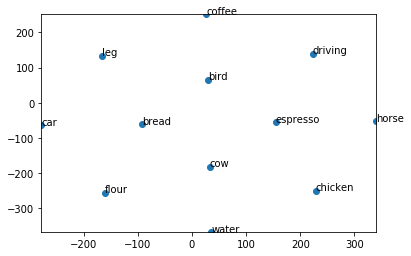

In [32]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(some_words, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

Well, this is still somewhat terrible. The words seem to be a bit better now, looks like some sentences are there, but this model has hit its limits and it doesn't appear that more training time will help at all.